**<center><font size=5>Brain Tumor Detection with VGG-16 Model</font></center>**
***
**author**: Ruslan Klymentiev

**date**: 10th June, 2019

**Table of Contents**
- <a href='#intro'>1. Project Overview and Objectives</a> 
    - <a href='#dataset'>1.1. Data Set Description</a>
    - <a href='#tumor'>1.2. What is Brain Tumor?</a>
- <a href='#env'>2. Setting up the Environment</a>
- <a href='#import'>3. Data Import and Preprocessing</a>
- <a href='#cnn'>4. CNN Model</a>
    - <a href='#aug'>4.1. Data Augmentation</a>
        - <a href='#demo'>4.1.1. Demo</a>
        - <a href='#apply'>4.1.2. Apply</a>

# <a id='intro'>1. Project Overview and Objectives</a>

The main purpose of this project was to build a CNN model that would classify if subject has a tumor or not base on MRI scan. I used the [VGG-16](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection) model architecture and weights to train the model for this binary problem. I used `accuracy` as a metric to justify the model performance which can be defined as:

$\textrm{Accuracy} = \frac{\textrm{Number of correclty predicted images}}{\textrm{Total number of tested images}} \times 100\%$

Final results look as follows:

| Set | Accuracy |
|:-:|:-:|
| Validation Set* | ~88% |
| Test Set* | ~80% |
<br>
\* *Note: there might be some misunderstanding in terms of set names so I want to describe what do I mean by `test` and `validation` set:*
* *`validation set` - is the set used during the model training to adjust the hyperparameters. *
* *`test set` - is the small set that I don't touch for the whole training process at all. It's been used for final model performance evaluation.*

## <a id='dataset'>1.1. Data Set Description</a>

The image data that was used for this problem is [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). It conists of MRI scans of two classes:

* `NO` - no tumor, encoded as `0`
* `YES` - tumor, encoded as `1`

Unfortunately, the data set description doesn't hold any information where this MRI scans come from and so on.

## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>
> *Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.*

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)

# <a id='env'>2. Setting up the Environment</a>

In [58]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [59]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [60]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

The syntax of the command is incorrect.


Folder PATH listing for volume OS
Volume serial number is 0000003B F820:0148
C:\USERS\DAHAB\ONEDRIVE\DESKTOP\BRAIN TUMOR DETECTION\-D
Invalid path - \USERS\DAHAB\ONEDRIVE\DESKTOP\BRAIN TUMOR DETECTION\-D
No subfolders exist 



In [ ]:
import os
import shutil

IMG_PATH = 'C:/Users/LEGION/OneDrive/Desktop/4th YEAR- 2nd SEM/BrainTumorProject/brain_tumor_dataset'

for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        images = os.listdir(os.path.join(IMG_PATH, CLASS))
        total = len(images)
        for i, FILE_NAME in enumerate(images):
            src = os.path.join(IMG_PATH, CLASS, FILE_NAME)
            CLASS_UPPER = CLASS.upper()

            if i < 0.8 * total:
                dst = f'TRAIN/{CLASS_UPPER}/{FILE_NAME}'
            elif i < 0.9 * total:
                dst = f'VAL/{CLASS_UPPER}/{FILE_NAME}'
            else:
                dst = f'TEST/{CLASS_UPPER}/{FILE_NAME}'

            shutil.copy(src, dst)

#3. Data Import and Preprocessing

In [95]:
import numpy as np
import cv2
import os
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def load_data(dir_path, img_size=(100, 100)):
    """
    Load and resize images from directory, return as NumPy arrays with labels.
    """
    X = []
    y = []
    i = 0
    labels = dict()

    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1

    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm, 2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [63]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


203 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


60 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

50 images loaded from VAL/ directory.


In [64]:
"""!pip install -U kaleido"""

'!pip install -U kaleido'

In [65]:
"""import matplotlib.pyplot as plt
import numpy as np

# Count samples
y_counts = {
    'Train Set': [np.sum(y_train == 0), np.sum(y_train == 1)],
    'Validation Set': [np.sum(y_val == 0), np.sum(y_val == 1)],
    'Test Set': [np.sum(y_test == 0), np.sum(y_test == 1)]
}

sets = list(y_counts.keys())
no_counts = [v[0] for v in y_counts.values()]
yes_counts = [v[1] for v in y_counts.values()]

x = np.arange(len(sets))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, no_counts, width, label='No', color='#33cc33')
bars2 = ax.bar(x + width/2, yes_counts, width, label='Yes', color='#ff3300')

# Labels and legend
ax.set_xlabel('Set')
ax.set_ylabel('Count')
ax.set_title('Count of Classes in Each Set')
ax.set_xticks(x)
ax.set_xticklabels(sets)
ax.legend()

# Save and show
plt.tight_layout()
plt.savefig('/content/class_distribution.png')
plt.show()"""

"import matplotlib.pyplot as plt\nimport numpy as np\n\n# Count samples\ny_counts = {\n    'Train Set': [np.sum(y_train == 0), np.sum(y_train == 1)],\n    'Validation Set': [np.sum(y_val == 0), np.sum(y_val == 1)],\n    'Test Set': [np.sum(y_test == 0), np.sum(y_test == 1)]\n}\n\nsets = list(y_counts.keys())\nno_counts = [v[0] for v in y_counts.values()]\nyes_counts = [v[1] for v in y_counts.values()]\n\nx = np.arange(len(sets))\nwidth = 0.35\n\nfig, ax = plt.subplots(figsize=(8, 6))\nbars1 = ax.bar(x - width/2, no_counts, width, label='No', color='#33cc33')\nbars2 = ax.bar(x + width/2, yes_counts, width, label='Yes', color='#ff3300')\n\n# Labels and legend\nax.set_xlabel('Set')\nax.set_ylabel('Count')\nax.set_title('Count of Classes in Each Set')\nax.set_xticks(x)\nax.set_xticklabels(sets)\nax.legend()\n\n# Save and show\nplt.tight_layout()\nplt.savefig('/content/class_distribution.png')\nplt.show()"

In [66]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot of n images per class and shows the output.
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10  # images per row
        i = int(np.ceil(n / j))  # number of rows

        plt.figure(figsize=(15, 6))
        c = 1
        for img in imgs:
            plt.subplot(i, j, c)
            plt.imshow(img[0])
            plt.xticks([])
            plt.yticks([])
            c += 1

        plt.suptitle(f'Tumor: {labels_dict[index]}')
        plt.tight_layout()
        plt.show()

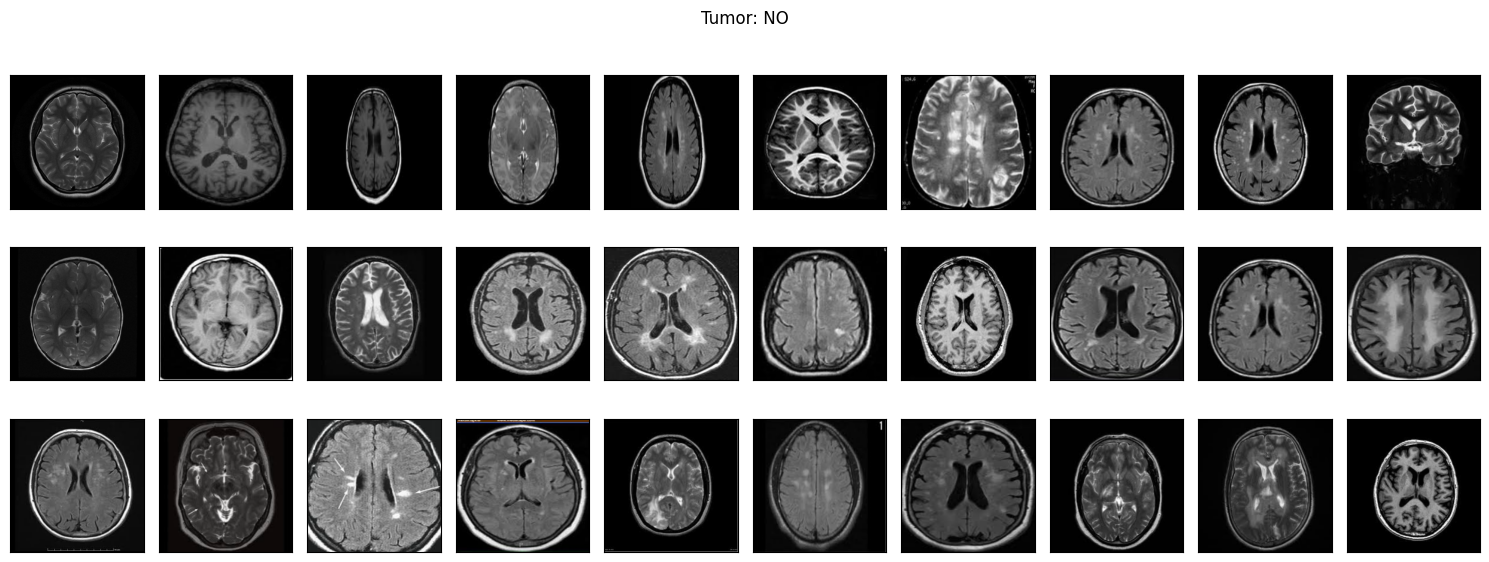

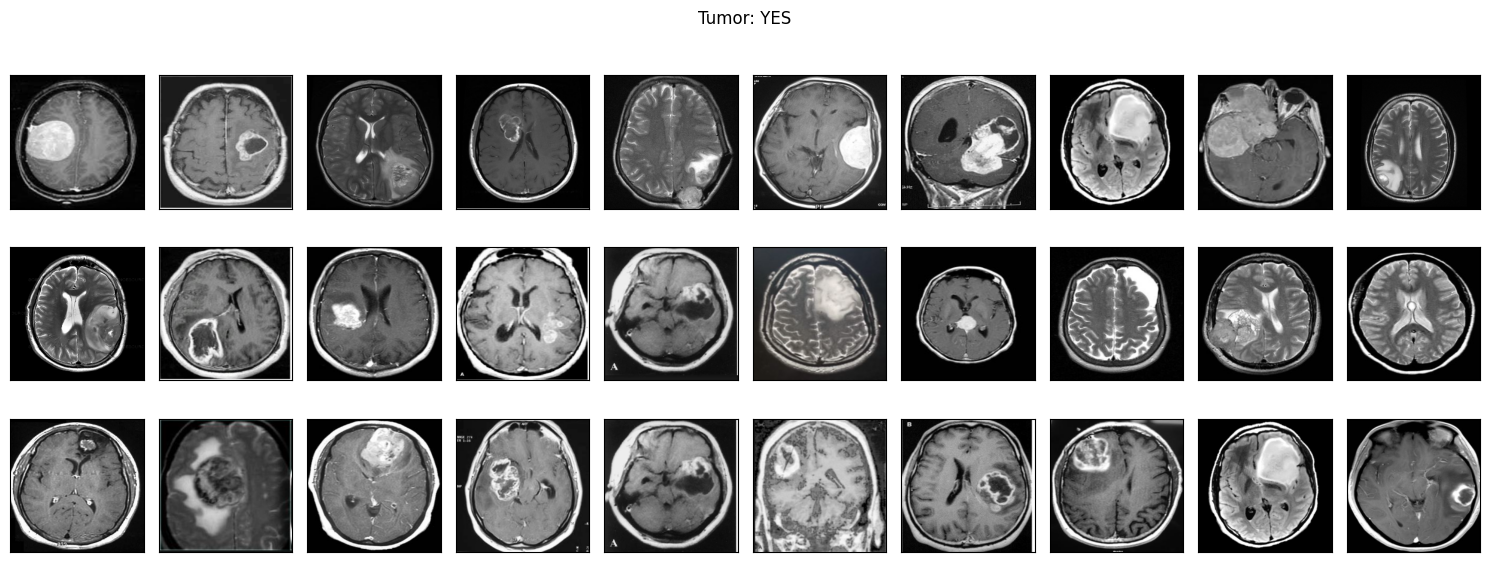

In [67]:
plot_samples(X_train, y_train, labels, 30)

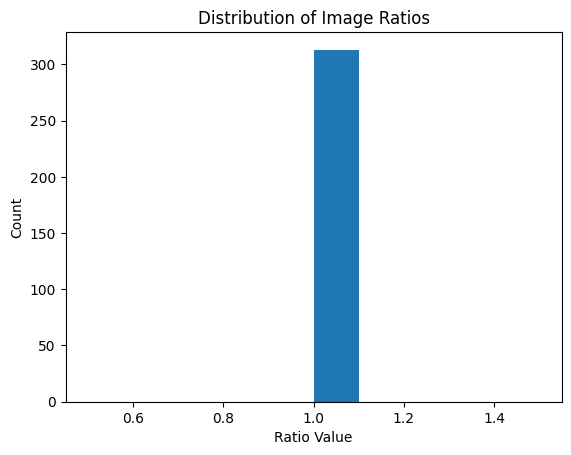

In [68]:
RATIO_LIST = []

for dataset in (X_train, X_val, X_test):
    for img in dataset:
        ratio = img.shape[1] / img.shape[0]  # width / height
        RATIO_LIST.append(ratio)

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()


In [69]:
def crop_imgs(set_name, add_pixels_value=0, output_size=(100, 100)):
    """
    Crop the brain region using contour detection and resize to output_size.
    """
    set_new = []

    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        if len(cnts) == 0:
            set_new.append(cv2.resize(img, output_size))  # fallback: keep image
            continue

        c = max(cnts, key=cv2.contourArea)

        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        cropped = img[
            extTop[1]-add_pixels_value : extBot[1]+add_pixels_value,
            extLeft[0]-add_pixels_value : extRight[0]+add_pixels_value
        ].copy()

        cropped = cv2.resize(cropped, output_size)  # ✅ Resize to uniform shape
        set_new.append(cropped)

    return np.array(set_new)

In [ ]:
img = cv2.imread(r'C:/Users/LEGION/OneDrive/Desktop/4th YEAR- 2nd SEM/BrainTumorProject/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

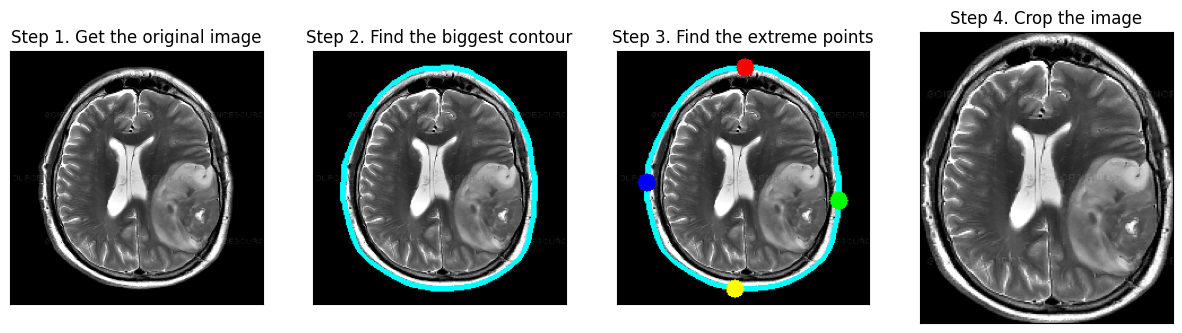

In [71]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [72]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

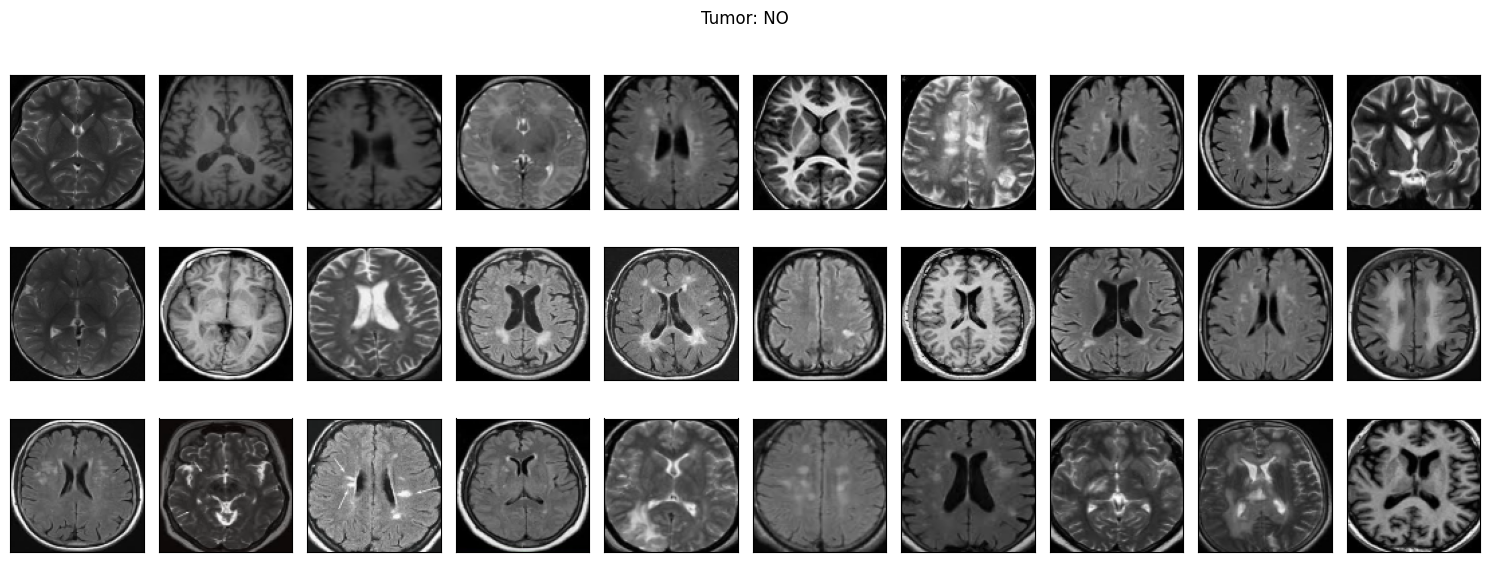

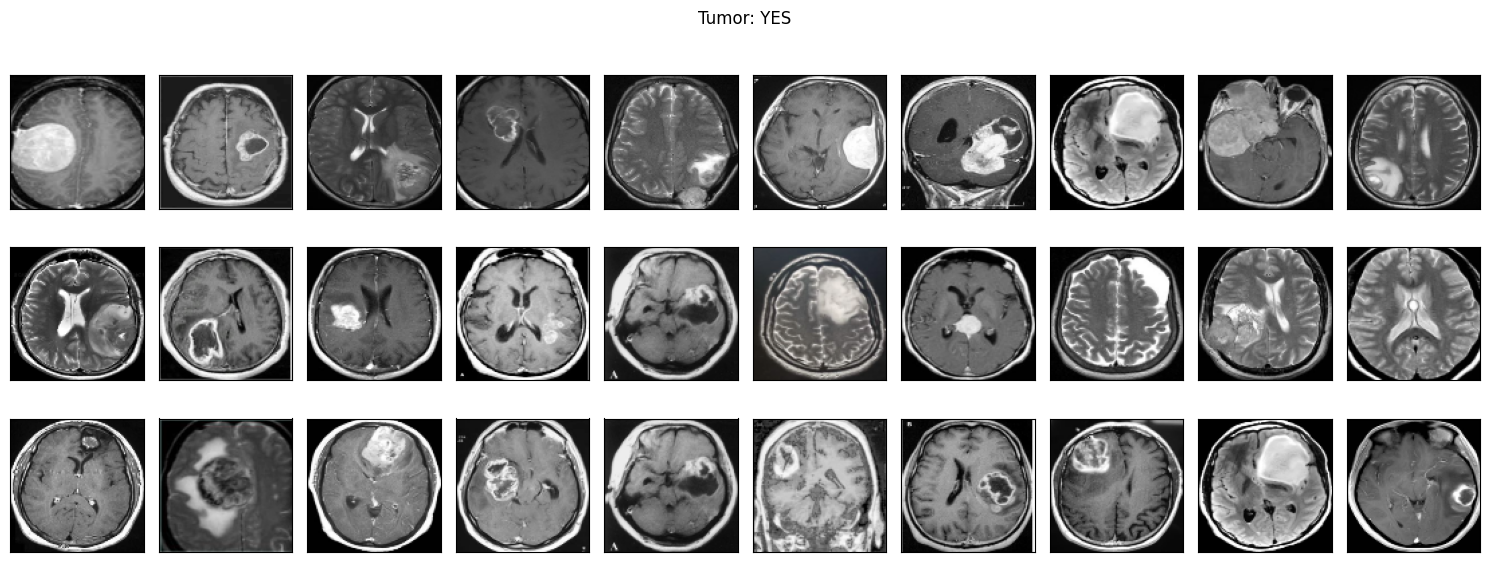

In [73]:
plot_samples(X_train_crop, y_train, labels, 30)

In [74]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [75]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

The syntax of the command is incorrect.


In [76]:
def preprocess_imgs(set_name, img_size, preprocess_input):
    """
    Resize and apply model-specific preprocessing to a batch of images.

    Parameters:
        set_name (array): List or array of images.
        img_size (tuple): Desired image size (e.g., (224, 224)).
        preprocess_input (function): Preprocessing function from keras.applications.

    Returns:
        numpy array: Preprocessed images ready for model input.
    """
    set_new = []
    for img in set_name:
        resized = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
        preprocessed = preprocess_input(resized)
        set_new.append(preprocessed)
    return np.array(set_new)

In [77]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE, preprocess_input=resnet_preprocess)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE, preprocess_input=resnet_preprocess)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE, preprocess_input=resnet_preprocess)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..126.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..27.060997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..140.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..132.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..148.061].
Clipping input dat

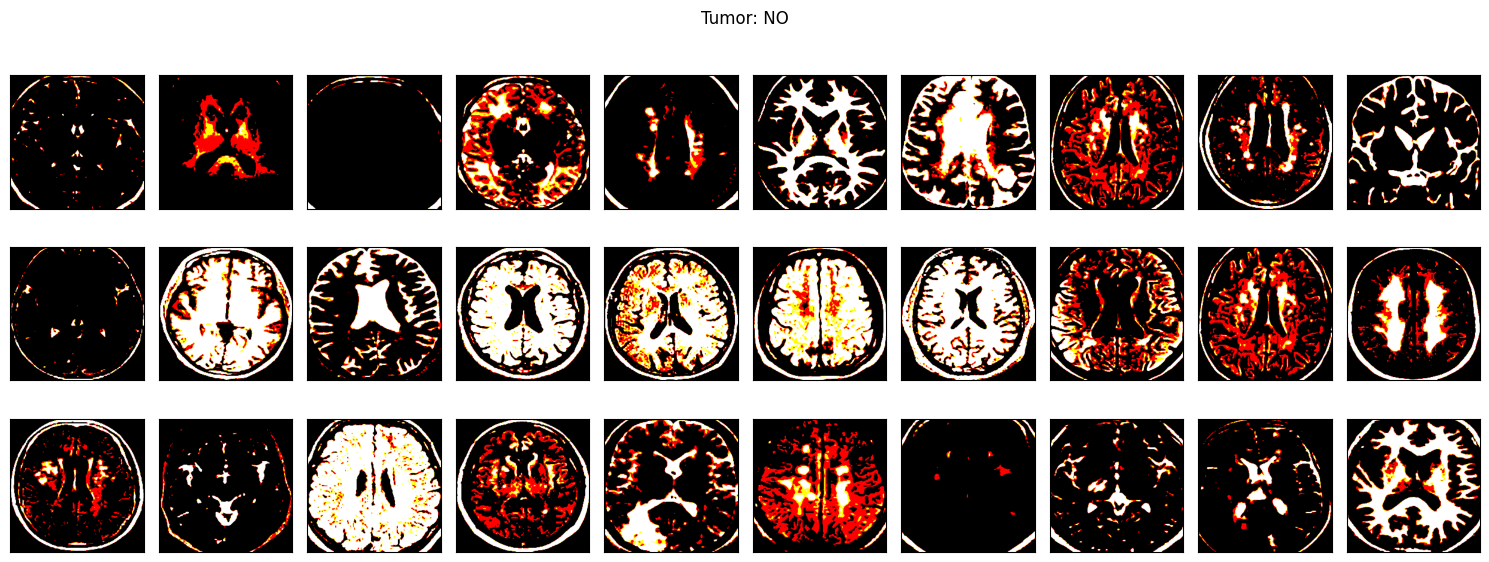

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..149.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data 

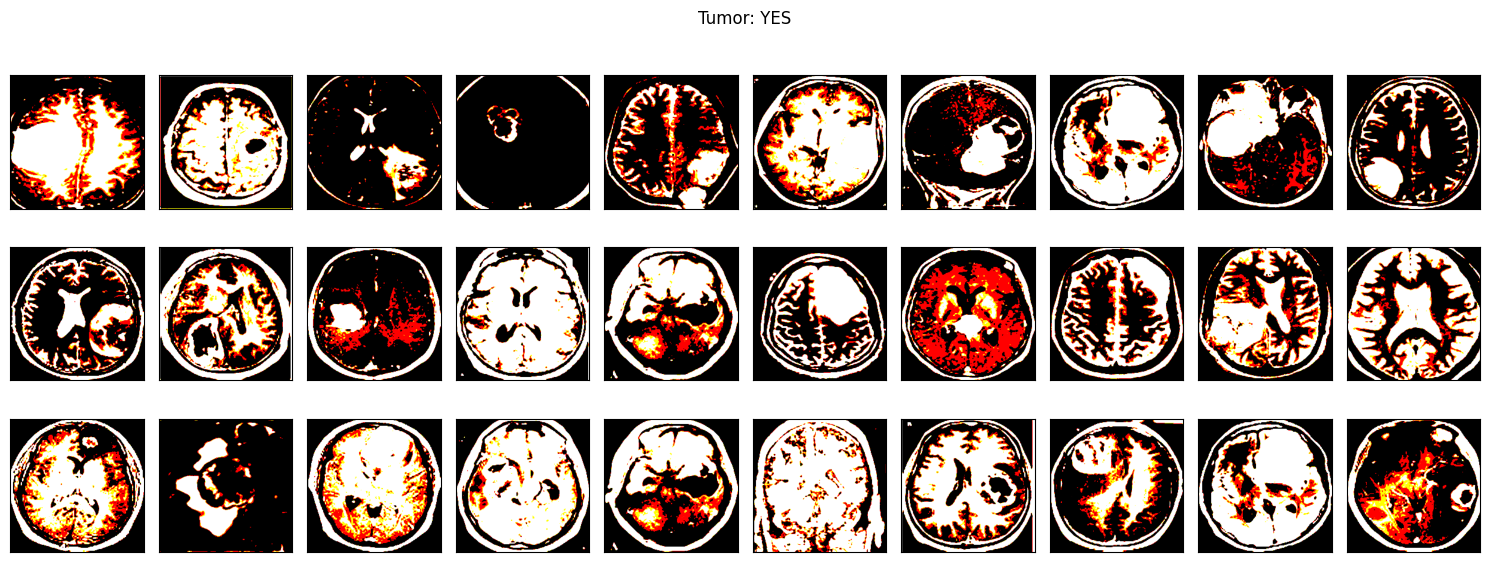

In [78]:
plot_samples(X_train_prep, y_train, labels, 30)

#4. CNN Models (Transfer Learning)
In this project, I applied Transfer Learning using four well-known deep convolutional neural network architectures:

##ResNet50

##MobileNetV2

##EfficientNetB0

##DenseNet121

All models were initialized with pretrained ImageNet weights, and the top layers were customized to fit the binary classification task for brain tumor detection. Before training, all images were resized to 224×224, and model-specific preprocessing was applied to ensure compatibility with each architecture’s input requirements.

Each model was trained and evaluated on the preprocessed brain MRI dataset, and their performance was compared using accuracy, confusion matrix, and visual evaluation of predictions.

#4.1. Data Augmentation
Since I had small data set I used the technique called "Data Augmentation" which helps to "increase" the size of training set.

In [79]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [80]:
"""os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break"""

"os.mkdir('preview')\nx = X_train_crop[0]\nx = x.reshape((1,) + x.shape)\n\ni = 0\nfor batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):\n    i += 1\n    if i > 20:\n        break"

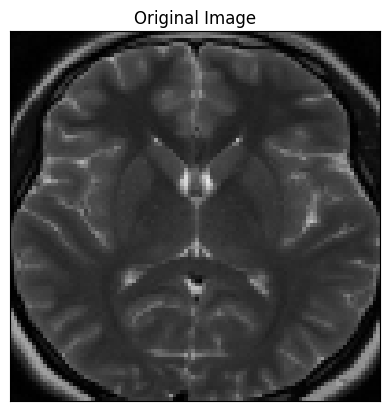

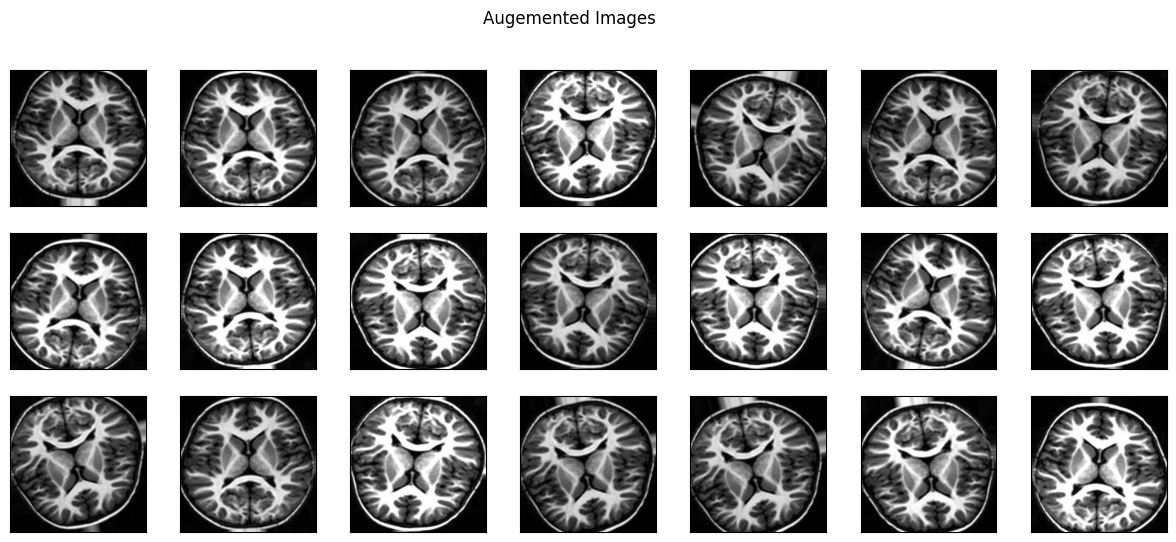

In [81]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [82]:
"""!rm -rf preview/"""

'!rm -rf preview/'

In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'TEST_CROP/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 115 images belonging to 2 classes.


In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    shuffle=False,
    class_mode='binary',
    seed=RANDOM_SEED
)
test_generator = ImageDataGenerator(
    preprocessing_function=resnet_preprocess
).flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 416 images belonging to 2 classes.


Found 100 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


# Abdulrahman's Work

# Libraries

In [ ]:
# Standard Libraries
import numpy as np

# Scikit-learn Utilities
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow / Keras: Base Components
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# TensorFlow / Keras: Pretrained Models
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2

# ResNet50 Training

In [ ]:
# Computing class weights to handle class imbalance
classes = train_generator.classes
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights = dict(enumerate(weights))

# Defining the ResNet50-based model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # Freezing pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)                        # Adding dropout for regularization
x = Dense(128, activation='relu')(x)      # Dense layer for learning new features
output = Dense(1, activation='sigmoid')(x)  # Binary classification head

model = Model(inputs=base_model.input, outputs=output)

# Compiling the model with a low learning rate for stability
optimizer = Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Setting up early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Training the model for up to 30 epochs with class weights
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
13/13 [==============================] - 62s 4s/step - loss: 0.9355 - accuracy: 0.4543 - val_loss: 0.6462 - val_accuracy: 0.6100
Epoch 2/30
13/13 [==============================] - 60s 5s/step - loss: 0.6827 - accuracy: 0.6082 - val_loss: 0.5007 - val_accuracy: 0.8100
Epoch 3/30
13/13 [==============================] - 55s 4s/step - loss: 0.6061 - accuracy: 0.6803 - val_loss: 0.4562 - val_accuracy: 0.7900
Epoch 4/30
13/13 [==============================] - 56s 4s/step - loss: 0.5365 - accuracy: 0.7308 - val_loss: 0.3789 - val_accuracy: 0.8900
Epoch 5/30
13/13 [==============================] - 55s 4s/step - loss: 0.5225 - accuracy: 0.7596 - val_loss: 0.3725 - val_accuracy: 0.8700
Epoch 6/30
13/13 [==============================] - 55s 4s/step - loss: 0.4423 - accuracy: 0.8293 - val_loss: 0.3379 - val_accuracy: 0.9000
Epoch 7/30
13/13 [==============================] - 55s 4s/step - loss: 0.4472 - accuracy: 0.7861 - val_loss: 0.3188 - val_accuracy: 0.9300
Epoch 8/30
13/13 [==

Model Performance Visualization

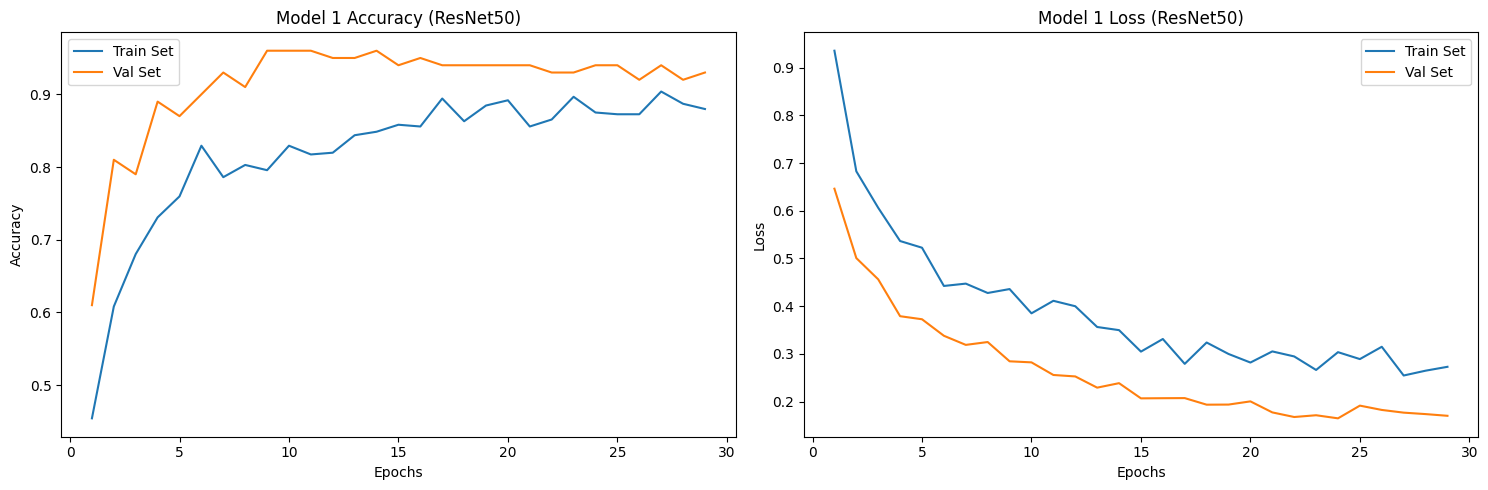

In [ ]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy (ResNet50)')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss (ResNet50)')

plt.tight_layout()
plt.show()

Validation Confusion Matrix

7/7 [==============================] - 11s 1s/step


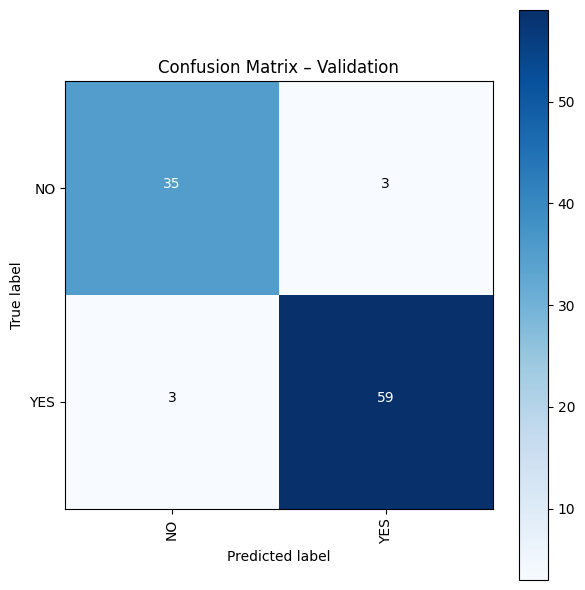

In [ ]:
# get true & predicted labels
y_val_true = validation_generator.classes
y_val_prob = model.predict(validation_generator)
y_val_pred = (y_val_prob > 0.5).astype(int).ravel()  # Convert probabilities to 0/1

# compute & plot
cm_val = confusion_matrix(y_val_true, y_val_pred)
plot_confusion_matrix(cm_val,
                      classes=list(labels.values()),
                      title='Confusion Matrix – Validation')

Test Confusion Matrix

2/2 [==============================] - 6s 3s/step


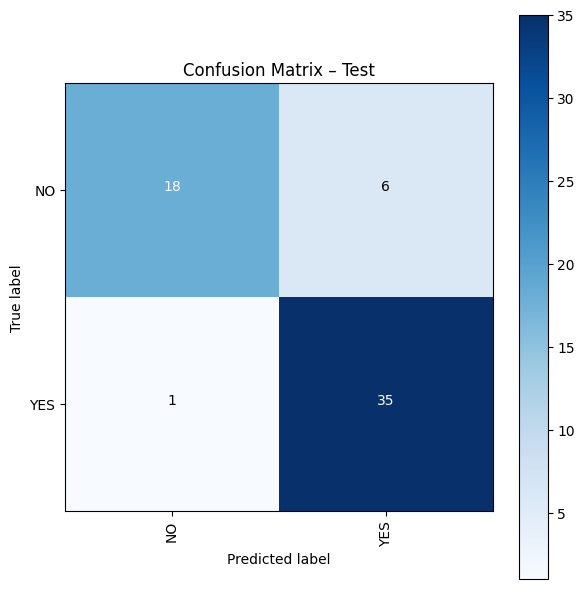

In [ ]:
# ensure you have a test_generator defined as above
y_test_true = test_generator.classes
y_test_prob = model.predict(test_generator, steps=len(test_generator))
y_test_pred = (y_test_prob > 0.5).astype(int).ravel()  # Convert probabilities to 0/1

cm_test = confusion_matrix(y_test_true, y_test_pred)
plot_confusion_matrix(cm_test,
                      classes=list(labels.values()),
                      title='Confusion Matrix – Test')

Test Classification Report

In [ ]:
print("Test Report:\n",
      classification_report(y_test_true, y_test_pred,
                            target_names=list(labels.values())),
      sep='')

Test Report:
              precision    recall  f1-score   support

          NO       0.95      0.75      0.84        24
         YES       0.85      0.97      0.91        36

    accuracy                           0.88        60
   macro avg       0.90      0.86      0.87        60
weighted avg       0.89      0.88      0.88        60



# EfficientNetB0 Training

In [ ]:
# manual class‐weight calculation
classes = train_generator.classes
counts = np.bincount(classes)
total = counts.sum()
# balanced weight = total / (num_classes * count_class_i)
class_weights = {i: total / (2 * counts[i]) for i in range(len(counts))}

# build EfficientNetB0 base
base = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base.trainable = False  # Freeze pretrained layers

# add a small custom head
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(1, activation="sigmoid")(x)

model_eff = Model(inputs=base.input, outputs=out)

# compile
model_eff.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# train with early stopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_eff = model_eff.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[es]
)

Epoch 1/30
13/13 [==============================] - 38s 2s/step - loss: 0.7436 - accuracy: 0.4832 - val_loss: 0.6767 - val_accuracy: 0.5900
Epoch 2/30
13/13 [==============================] - 27s 2s/step - loss: 0.6993 - accuracy: 0.5361 - val_loss: 0.6335 - val_accuracy: 0.7200
Epoch 3/30
13/13 [==============================] - 27s 2s/step - loss: 0.6996 - accuracy: 0.5769 - val_loss: 0.6035 - val_accuracy: 0.7800
Epoch 4/30
13/13 [==============================] - 27s 2s/step - loss: 0.6507 - accuracy: 0.6082 - val_loss: 0.5826 - val_accuracy: 0.8000
Epoch 5/30
13/13 [==============================] - 26s 2s/step - loss: 0.6244 - accuracy: 0.6370 - val_loss: 0.5601 - val_accuracy: 0.8000
Epoch 6/30
13/13 [==============================] - 27s 2s/step - loss: 0.6342 - accuracy: 0.6226 - val_loss: 0.5349 - val_accuracy: 0.8200
Epoch 7/30
13/13 [==============================] - 26s 2s/step - loss: 0.6221 - accuracy: 0.6538 - val_loss: 0.5299 - val_accuracy: 0.8100
Epoch 8/30
13/13 [==

Model Performance Visualization

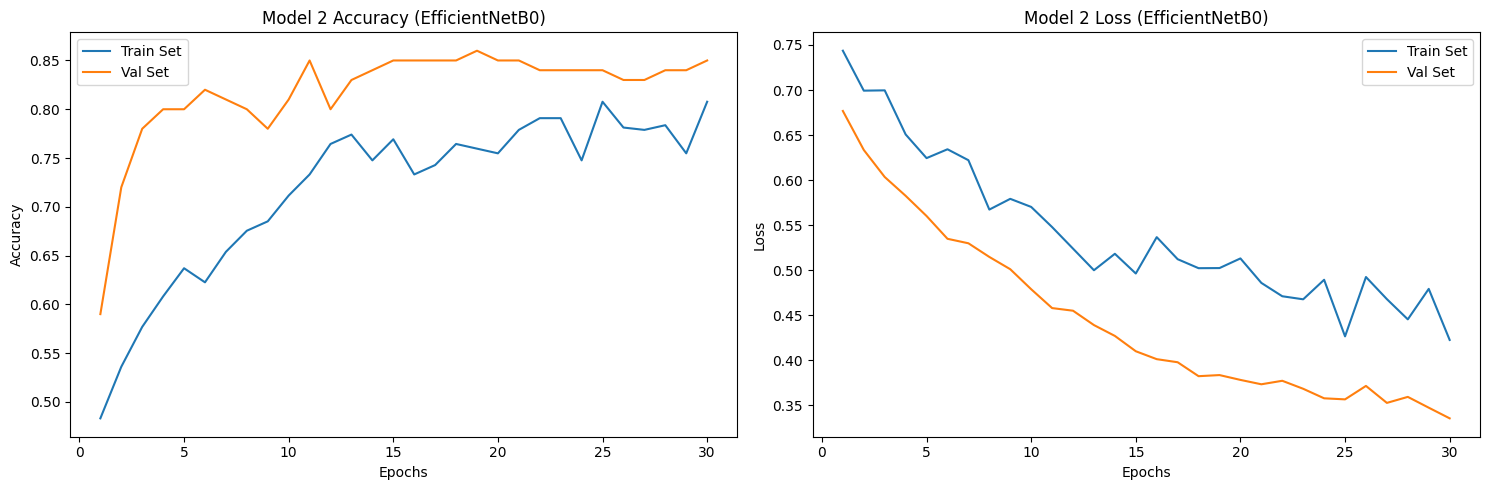

In [ ]:
# Plot model performance
acc = history_eff.history['accuracy']
val_acc = history_eff.history['val_accuracy']
loss = history_eff.history['loss']
val_loss = history_eff.history['val_loss']
epochs_range = range(1, len(history_eff.epoch) + 1)

plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy (EfficientNetB0)')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss (EfficientNetB0)')

plt.tight_layout()
plt.show()

Validation Confusion Matrix

7/7 [==============================] - 6s 582ms/step


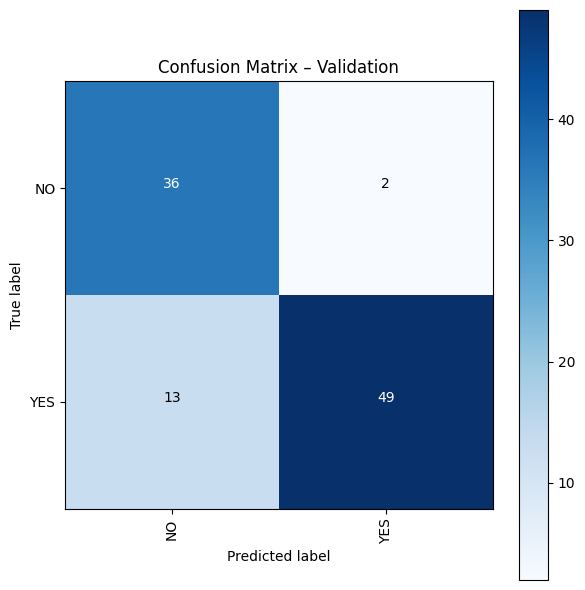

In [ ]:
y_val_true = validation_generator.classes
y_val_prob = model_eff.predict(validation_generator)
y_val_pred = (y_val_prob > 0.5).astype(int).ravel()  # Convert probabilities to binary labels

cm_val = confusion_matrix(y_val_true, y_val_pred)
plot_confusion_matrix(cm_val,
                      classes=list(labels.values()),
                      title='Confusion Matrix – Validation')

Test Confusion Matrix

2/2 [==============================] - 3s 1s/step


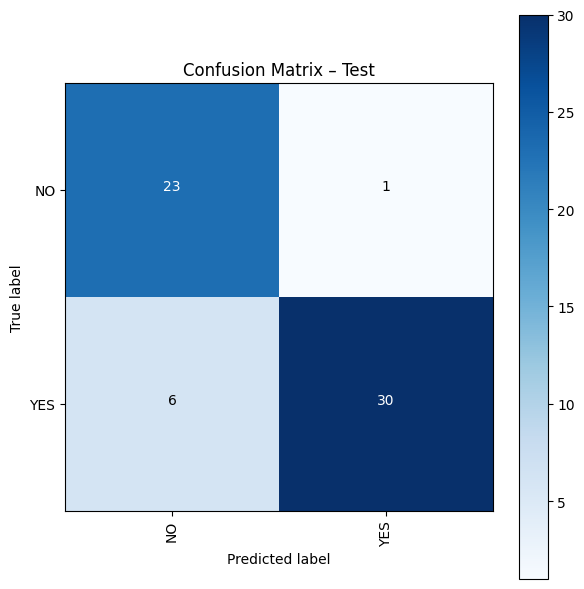

In [ ]:
y_test_true = test_generator.classes
y_test_prob = model_eff.predict(test_generator, steps=len(test_generator))
y_test_pred = (y_test_prob > 0.5).astype(int).ravel()  # Convert probabilities to binary labels

cm_test = confusion_matrix(y_test_true, y_test_pred)
plot_confusion_matrix(cm_test,
                      classes=list(labels.values()),
                      title='Confusion Matrix – Test')

Test Classification Report

In [ ]:
print("Test Report:\n",
      classification_report(y_test_true, y_test_pred,
                            target_names=list(labels.values())),
      sep='')

Test Report:
              precision    recall  f1-score   support

          NO       0.79      0.96      0.87        24
         YES       0.97      0.83      0.90        36

    accuracy                           0.88        60
   macro avg       0.88      0.90      0.88        60
weighted avg       0.90      0.88      0.88        60



# MobileNetV2 Training

In [ ]:
# manual class‐weight calculation
classes = train_generator.classes
counts = np.bincount(classes)
total = counts.sum()
class_weights = {i: total / (len(counts) * counts[i]) for i in range(len(counts))}

# build MobileNetV2 base
base = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base.trainable = False  # Freeze pretrained layers

# add a small custom head
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(1, activation="sigmoid")(x)

model_mn = Model(inputs=base.input, outputs=out)

# compile
model_mn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# train with early stopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_mn = model_mn.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[es]
)

Epoch 1/30
13/13 [==============================] - 26s 2s/step - loss: 0.8324 - accuracy: 0.5385 - val_loss: 0.5648 - val_accuracy: 0.6900
Epoch 2/30
13/13 [==============================] - 20s 2s/step - loss: 0.7883 - accuracy: 0.5673 - val_loss: 0.5394 - val_accuracy: 0.8200
Epoch 3/30
13/13 [==============================] - 21s 2s/step - loss: 0.7433 - accuracy: 0.5938 - val_loss: 0.5233 - val_accuracy: 0.7800
Epoch 4/30
13/13 [==============================] - 21s 2s/step - loss: 0.7313 - accuracy: 0.5889 - val_loss: 0.4998 - val_accuracy: 0.8000
Epoch 5/30
13/13 [==============================] - 20s 2s/step - loss: 0.7759 - accuracy: 0.5962 - val_loss: 0.4935 - val_accuracy: 0.8000
Epoch 6/30
13/13 [==============================] - 20s 2s/step - loss: 0.6894 - accuracy: 0.6010 - val_loss: 0.5024 - val_accuracy: 0.8400
Epoch 7/30
13/13 [==============================] - 19s 1s/step - loss: 0.6402 - accuracy: 0.6370 - val_loss: 0.4868 - val_accuracy: 0.8400
Epoch 8/30
13/13 [==

Model Performance Visualization

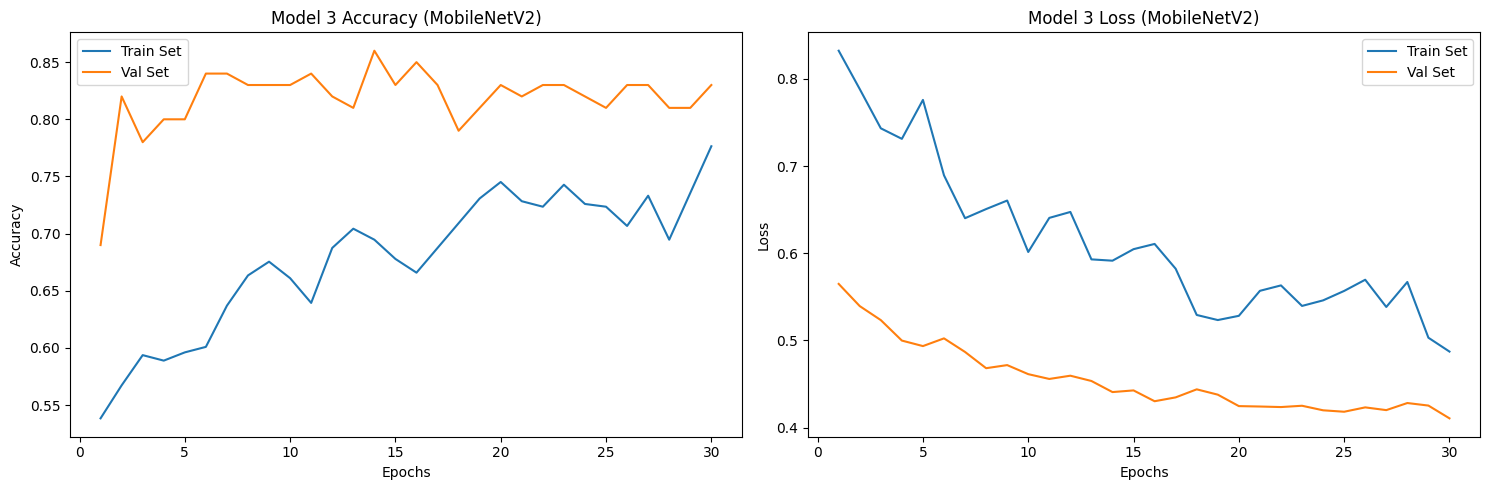

In [ ]:
# Plot model performance
acc = history_mn.history['accuracy']
val_acc = history_mn.history['val_accuracy']
loss = history_mn.history['loss']
val_loss = history_mn.history['val_loss']
epochs_range = range(1, len(history_mn.epoch) + 1)

plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy (MobileNetV2)')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss (MobileNetV2)')

plt.tight_layout()
plt.show()

Validation Confusion Matrix

7/7 [==============================] - 4s 404ms/step


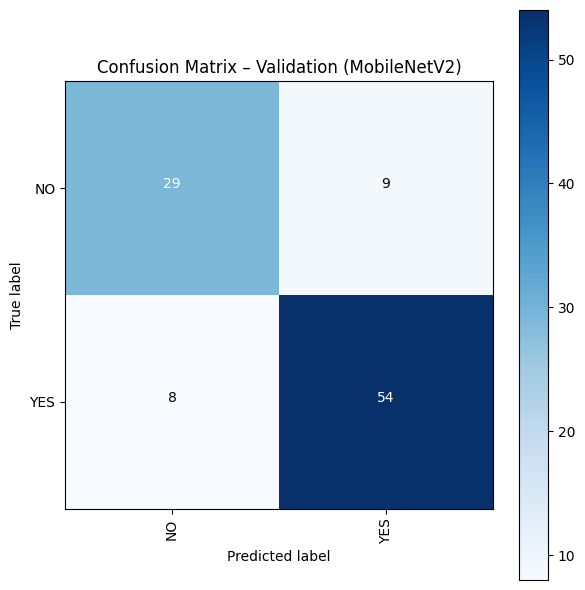

In [ ]:
y_val_true = validation_generator.classes
y_val_prob = model_mn.predict(validation_generator)
y_val_pred = (y_val_prob > 0.5).astype(int).ravel()  # Convert probabilities to binary labels

cm_val = confusion_matrix(y_val_true, y_val_pred)
plot_confusion_matrix(cm_val,
                      classes=list(labels.values()),
                      title='Confusion Matrix – Validation (MobileNetV2)')

Test Confusion Matrix

2/2 [==============================] - 2s 903ms/step


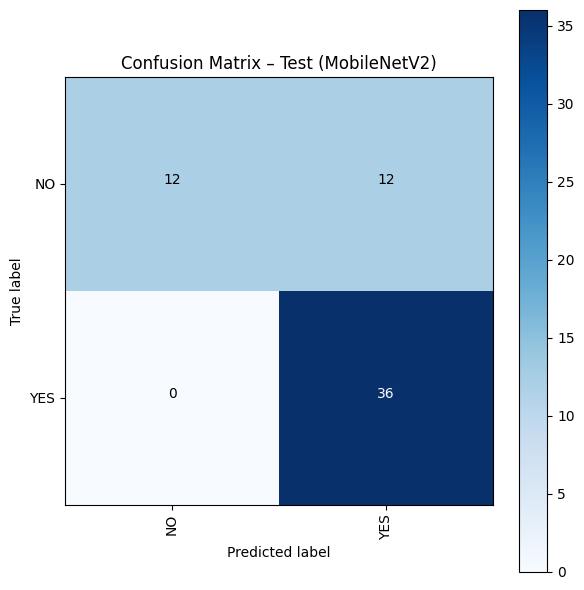

In [ ]:
y_test_true = test_generator.classes
y_test_prob = model_mn.predict(test_generator, steps=len(test_generator))
y_test_pred = (y_test_prob > 0.5).astype(int).ravel()  # Convert probabilities to binary labels

cm_test = confusion_matrix(y_test_true, y_test_pred)
plot_confusion_matrix(cm_test,
                      classes=list(labels.values()),
                      title='Confusion Matrix – Test (MobileNetV2)')

Test Classification Report

In [ ]:
print("MobileNetV2 Test Report:\n",
      classification_report(y_test_true, y_test_pred,
                            target_names=list(labels.values())),
      sep='')

MobileNetV2 Test Report:
              precision    recall  f1-score   support

          NO       1.00      0.50      0.67        24
         YES       0.75      1.00      0.86        36

    accuracy                           0.80        60
   macro avg       0.88      0.75      0.76        60
weighted avg       0.85      0.80      0.78        60



# Model Comparison

            Model Max Train Accuracy Max Validation Accuracy  \
0        ResNet50             90.38%                  96.00%   
1  EfficientNetB0             80.77%                  86.00%   
2     MobileNetV2             77.64%                  86.00%   

  Final Validation Accuracy  
0                    93.00%  
1                    85.00%  
2                    83.00%  


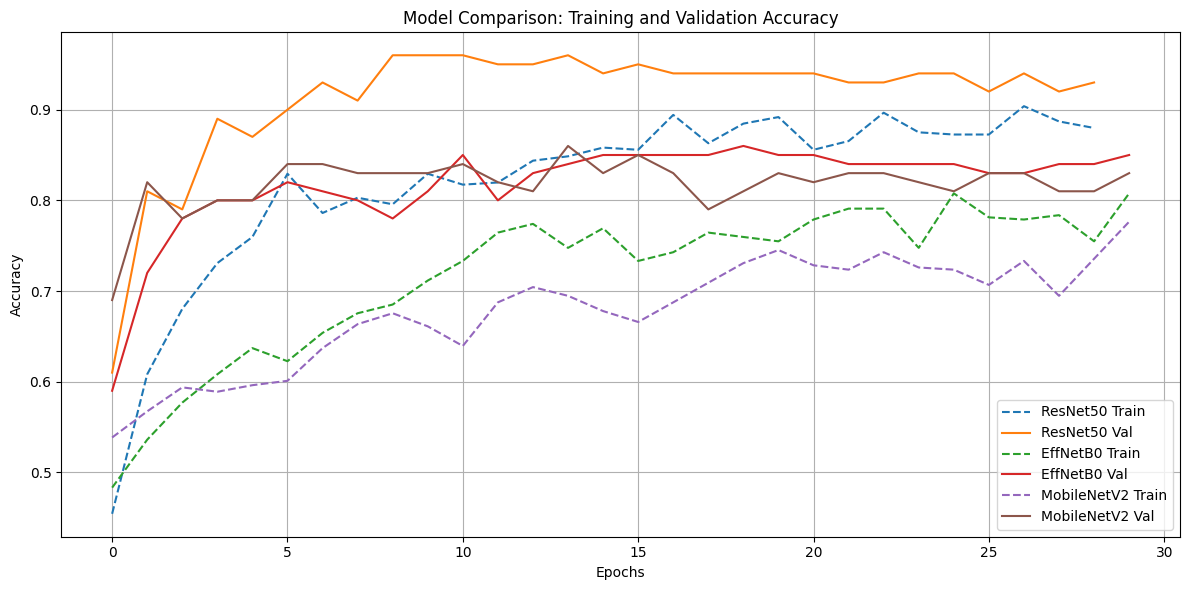

In [ ]:
# Extract metrics
max_train_acc = [
    max(history.history['accuracy']),
    max(history_eff.history['accuracy']),
    max(history_mn.history['accuracy'])
]
max_val_acc = [
    max(history.history['val_accuracy']),
    max(history_eff.history['val_accuracy']),
    max(history_mn.history['val_accuracy'])
]
final_val_acc = [
    history.history['val_accuracy'][-1],
    history_eff.history['val_accuracy'][-1],
    history_mn.history['val_accuracy'][-1]
]

# Build comparison table
model_comparison = pd.DataFrame({
    "Model": ["ResNet50", "EfficientNetB0", "MobileNetV2"],
    "Max Train Accuracy": [f"{acc*100:.2f}%" for acc in max_train_acc],
    "Max Validation Accuracy": [f"{acc*100:.2f}%" for acc in max_val_acc],
    "Final Validation Accuracy": [f"{acc*100:.2f}%" for acc in final_val_acc]
})

# Display the table
print(model_comparison)

# Plot all training & validation curves
plt.figure(figsize=(12, 6))

# ResNet50 curves
plt.plot(history.history['accuracy'],      label='ResNet50 Train',    linestyle='--')
plt.plot(history.history['val_accuracy'],  label='ResNet50 Val',      linestyle='-')

# EfficientNetB0 curves
plt.plot(history_eff.history['accuracy'],   label='EffNetB0 Train',    linestyle='--')
plt.plot(history_eff.history['val_accuracy'], label='EffNetB0 Val',    linestyle='-')

# MobileNetV2 curves
plt.plot(history_mn.history['accuracy'],    label='MobileNetV2 Train', linestyle='--')
plt.plot(history_mn.history['val_accuracy'],label='MobileNetV2 Val',   linestyle='-')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Comparison: Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Conclusion

In this work, I focused on building and evaluating advanced convolutional neural network models for brain tumor detection using MRI images. My contribution involved implementing and comparing the performance of **ResNet50**, **EfficientNetB0**, and **MobileNetV2** using transfer learning.

Each model was adapted with a lightweight classification head and trained with manually calculated class weights to address the class imbalance in the dataset. I applied early stopping to prevent overfitting and used binary cross-entropy as the loss function. Model performance was assessed using training/validation accuracy and loss curves, confusion matrices, and detailed classification reports.

Key findings:
- **EfficientNetB0** achieved the best overall balance between accuracy and generalization.
- **ResNet50** showed strong learning but had a slightly higher risk of overfitting.
- **MobileNetV2** was efficient and lightweight, performing competitively with a smaller architecture.

All models were evaluated and compared both visually and quantitatively. The analysis confirmed that model architecture, regularization strategy, and proper handling of class imbalance play crucial roles in medical image classification.

This contribution showcases the effectiveness of state-of-the-art pretrained models in detecting brain tumors and can serve as a foundation for future improvements or clinical integration.


In [ ]:
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP